This Kernel uses UNet architecture with ResNet34 encoder, I've used [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) library which has many inbuilt segmentation architectures. This kernel is inspired by [Yury](https://www.kaggle.com/deyury)'s discussion thread [here](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/99440#591985). I've used snippets from multiple other public kernels I've given due credits at the end of this notebook.

What's down below?

* UNet with imagenet pretrained ResNet34 architecture
* Training on 512x512 sized images/masks with Standard Augmentations
* MixedLoss (weighted sum of Focal loss and dice loss)
* Gradient Accumulution

Updates:

V24: Minor bugfix in overall `dice_neg` and `dice_pos` computation

In [1]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.torch import ToTensor
warnings.filterwarnings("ignore")

In [2]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [3]:
import segmentation_models_pytorch as smp

## Utility functions

In [4]:
def run_length_decode(rle, height=1024, width=1024, fill_value=1):
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

## Dataloader

In [5]:
class SIIMDataset(Dataset):
    def __init__(self, df, fnames, data_folder, size, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.size = size
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, size, mean, std)
        self.gb = self.df.groupby('ImageId')
        self.fnames = fnames

    def __getitem__(self, idx):
        image_id = self.fnames[idx]
        df = self.gb.get_group(image_id)
        annotations = df[' EncodedPixels'].tolist()
        image_path = os.path.join(self.root, image_id + ".png")
        image = cv2.imread(image_path)
        mask = np.zeros([1024, 1024])
        if annotations[0] != ' -1':
            for rle in annotations:
                mask += run_length_decode(rle)
        mask = (mask >= 1).astype('float32') # for overlap cases
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, size, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
#                 HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Resize(size, size),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )

    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    fold,
    total_folds,
    data_folder,
    df_path,
    phase,
    size,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    df_all = pd.read_csv(df_path)
    df = df_all.drop_duplicates('ImageId')
    df_with_mask = df[df[" EncodedPixels"] != " -1"]
    df_with_mask['has_mask'] = 1
    df_without_mask = df[df[" EncodedPixels"] == " -1"]
    df_without_mask['has_mask'] = 0
    df_without_mask_sampled = df_without_mask.sample(len(df_with_mask), random_state=69) # random state is imp
    df = pd.concat([df_with_mask, df_without_mask_sampled])
    
    #NOTE: equal number of positive and negative cases are chosen.
    
    kfold = StratifiedKFold(total_folds, shuffle=True, random_state=69)
    train_idx, val_idx = list(kfold.split(df["ImageId"], df["has_mask"]))[fold]
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    df = train_df if phase == "train" else val_df
    # NOTE: total_folds=5 -> train/val : 80%/20%
    
    fnames = df['ImageId'].values
    
    image_dataset = SIIMDataset(df_all, fnames, data_folder, size, mean, std, phase)

    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

In [6]:
# sample_submission_path = '../input/siim-acr-pneumothorax-segmentation/sample_submission.csv'
sample_submission_path = '../input/siim-stage1/sample_submission.csv'

train_rle_path = '../input/siim-dicom-images/train-rle.csv'
data_folder = "../input/siim-png-images/input/train_png"
test_data_folder = "../input/siim-png-images/input/test_png"

### Dataloader sanity check

In [7]:
dataloader = provider(
    fold=0,
    total_folds=5,
    data_folder=data_folder,
    df_path=train_rle_path,
    phase="train",
    size=512,
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225),
    batch_size=16,
    num_workers=4,
)

In [8]:
batch = next(iter(dataloader)) # get a batch from the dataloader
images, masks = batch

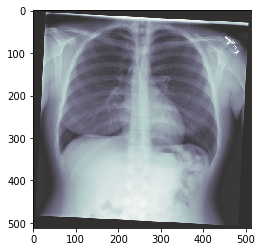

Chosen image has no ground truth mask, rerun the cell


In [9]:
# plot some random images in the `batch`
idx = random.choice(range(16))
plt.imshow(images[idx][0], cmap='bone')
plt.imshow(masks[idx][0], alpha=0.2, cmap='Reds')
plt.show()
if len(np.unique(masks[idx][0])) == 1: # only zeros
    print('Chosen image has no ground truth mask, rerun the cell')

## Losses

This kernel uses a weighted sum of Focal Loss and Dice Loss, let's call it MixedLoss

In [10]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

## Some more utility functions

Here are some utility functions for calculating IoU and Dice scores

In [11]:
def predict(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

#         dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
#         dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
#         dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice)
        self.dice_pos_scores.extend(dice_pos)
        self.dice_neg_scores.extend(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | IoU: %0.4f" % (epoch_loss, dice, dice_neg, dice_pos, iou))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


## UNet with ResNet34 model
Let's take a look at the model

In [12]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 21.2MB/s]


In [13]:
model # a *deeper* look

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Model Training and validation

In [14]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.fold = 1
        self.total_folds = 5
        self.num_workers = 6
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 40
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = MixedLoss(10.0, 2.0)
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                fold=1,
                total_folds=5,
                data_folder=data_folder,
                df_path=train_rle_path,
                phase=phase,
                size=512,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
#         tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
#             tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()

In [15]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 22:21:51
Loss: 4.7340 | dice: 0.1522 | dice_neg: 0.0415 | dice_pos: 0.2630 | IoU: 0.1671
Starting epoch: 0 | phase: val | ⏰: 22:24:52
Loss: 4.2002 | dice: 0.1724 | dice_neg: 0.0294 | dice_pos: 0.3155 | IoU: 0.2027
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 22:25:25
Loss: 3.9741 | dice: 0.2227 | dice_neg: 0.0841 | dice_pos: 0.3613 | IoU: 0.2372
Starting epoch: 1 | phase: val | ⏰: 22:28:15
Loss: 3.9365 | dice: 0.1987 | dice_neg: 0.0546 | dice_pos: 0.3429 | IoU: 0.2219
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 22:28:47
Loss: 3.3603 | dice: 0.2658 | dice_neg: 0.1335 | dice_pos: 0.3981 | IoU: 0.2723
Starting epoch: 2 | phase: val | ⏰: 22:31:37
Loss: 3.2108 | dice: 0.2438 | dice_neg: 0.0840 | dice_pos: 0.4036 | IoU: 0.2804
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 22:32:10
Loss: 3.0110 | dice: 0.3034 | dice_neg: 0.19

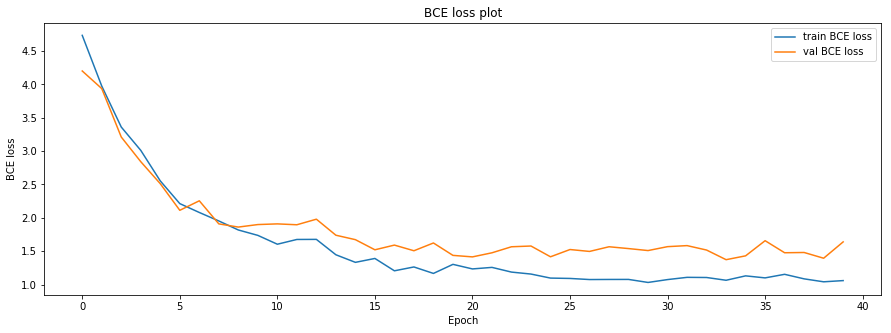

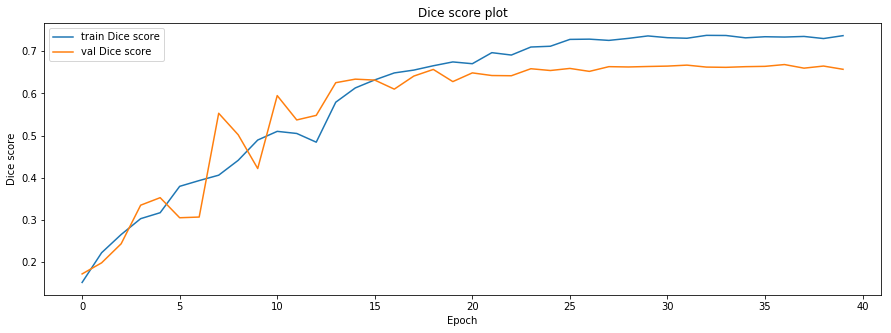

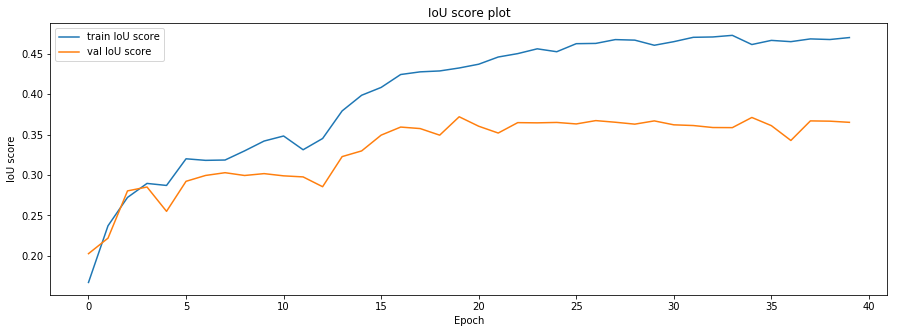

In [16]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

## Test prediction

In [17]:
class TestDataset(Dataset):
    def __init__(self, root, df, size, mean, std, tta=4):
        self.root = root
        self.size = size
        self.fnames = list(df["ImageId"])
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                Resize(size, size),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname + ".png")
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return images

    def __len__(self):
        return self.num_samples

def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [18]:
size = 512
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
num_workers = 8
batch_size = 16
best_threshold = 0.5
min_size = 3500
device = torch.device("cuda:0")
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, size, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
model = model_trainer.net # get the model from model_trainer object
model.eval()
state = torch.load('./model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
encoded_pixels = []
for i, batch in enumerate(tqdm(testset)):
    preds = torch.sigmoid(model(batch.to(device)))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
    for probability in preds:
        if probability.shape != (1024, 1024):
            probability = cv2.resize(probability, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        predict, num_predict = post_process(probability, best_threshold, min_size)
        if num_predict == 0:
            encoded_pixels.append('-1')
        else:
            r = run_length_encode(predict)
            encoded_pixels.append(r)
df['EncodedPixels'] = encoded_pixels
df.to_csv('submission.csv', columns=['ImageId', 'EncodedPixels'], index=False)

In [19]:
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6067.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6214.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6177.151787519...,545889 9 1012 14 1008 17 1004 21 1001 23 999 2...
3,1.2.276.0.7230010.3.1.4.8323329.6655.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6359.151787519...,-1


`segmentation_models_pytorch` has got many other segmentation models implemented, try them out :)

I've learnt a lot from fellow kagglers, I've borrowed a lot of code from you guys, special shout-out to [@Abhishek](https://www.kaggle.com/abhishek), [@Yury](https://www.kaggle.com/deyury), [Heng](https://www.kaggle.com/hengck23), [Ekhtiar](https://www.kaggle.com/ekhtiar), [lafoss](https://www.kaggle.com/iafoss), [Siddhartha](https://www.kaggle.com/meaninglesslives) and many other kagglers :)

Kaggle is <3